# Prerequisites

In [2]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare Data

In [3]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [4]:
for price in prices:
    price.scaled, price.scaler = data_transform(price, method=None)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled)

# Load Model Results

In [5]:
models = ['ets', 'arima', 'mlp', 'lstm']
for model in models:
    path = f'../results/result_{model}_4.pkl'
    res = joblib.load(path)
    for price in prices:
        setattr(price, f'{model}_grid_result', res[price.meta.abb][0])
        setattr(price, f'{model}_config', res[price.meta.abb][1])
        setattr(price, f'{model}_yhat', res[price.meta.abb][2])

In [6]:
for price in prices:
    print(price.ets_config)

('add', False, None)
('add', False, None)
('add', True, 'mul')


# Naive Forecast

In [7]:
def naive_forecast(data, n_forecast=4):
    train = data.train2
    test = data.test
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast
    yhat = np.empty((n_yhat, n_forecast))
    yhat[0] = train.iloc[-1]
    for i in range(1, n_yhat):
        yhat[i] = test.iloc[i-1]

    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)        
        
    return yhat

for price in prices:
    price.naive_yhat = naive_forecast(price)

# Mixed Forecast

In [8]:
col34 = ['yhat3', 'yhat4']
for price in prices:
    setattr(price, "mixed_yhat", price.arima_yhat.copy())
    price.mixed_yhat[col34] = price.lstm_yhat[col34].copy()

In [9]:
models = ['naive', 'ets', 'arima', 'mlp', 'lstm', 'mixed']

# Forecast Errors

In [10]:
for price in prices:
    for model in models:
        setattr(price, f'{model}_error', compute_error(price, model))

## Test Erorrs

In [11]:
error = compute_error(hml, 'mlp')
error.apply(lambda x : stats.ttest_1samp(x.dropna(), 0), axis=0)

err1    (-0.6387299901033923, 0.5248006059478962)
err2    (-0.8682968703736932, 0.3878291848608597)
err3    (-0.953322588051321, 0.34333452535552933)
err4    (-0.6334170297731498, 0.5283143036841326)
dtype: object

# Model Evaluation

In [12]:
rmse_list = [f'rmse{i+1}' for i in range(4)]
res = []
for model in models:
    for price in prices:
        yhat = getattr(price, f'{model}_yhat')
        idx = [model+'-'+price.meta.abb]
        df = model_measure(price, yhat, idx)
        df2 = pd.DataFrame(np.array(compute_rmse(price, model)).reshape(1,-1),
                           columns=rmse_list,
                           index=idx)
        res.append(df.join(df2))
model_eval = pd.concat(res)
model_eval

,rmse,mae,mape,rmse1,rmse2,rmse3,rmse4
config,,,,,,,
naive-hml,933.3045,625.6296,0.0507,497.5640,812.1493,"1,038.2096","1,224.4157"
naive-wht,494.7844,371.3673,0.0463,293.5626,455.2090,558.0616,611.8983
naive-glu,868.8724,629.2562,0.0576,514.7739,787.7860,962.1912,"1,099.2481"
ets-hml,950.2389,647.5365,0.0525,499.0278,820.6326,"1,056.2939","1,254.4291"
ets-wht,512.4657,379.6580,0.0474,295.9516,465.1051,576.9546,643.1934
ets-glu,765.2775,608.7771,0.0552,484.9153,696.6605,834.9634,961.7465
arima-hml,698.6862,424.1819,0.0345,147.0701,472.3742,797.1509,"1,035.5834"
arima-wht,390.6162,267.3351,0.0333,122.0173,264.9360,451.5995,566.8358
arima-glu,672.5283,452.0021,0.0411,204.2556,489.3520,764.7818,971.1335


In [67]:
model_eval.to_excel("../results/model_eval.xlsx")

# Save Results

In [13]:
writer = pd.ExcelWriter("../results/grid_mlp.xlsx", engine='xlsxwriter')
for price in prices:
    price.mlp_grid_result.to_excel(writer, sheet_name=price.meta.abb)
writer.save()

In [ ]:
writer = pd.ExcelWriter("../results/grid_lstm.xlsx", engine='xlsxwriter')
for price in prices:
    price.lstm_grid_result.to_excel(writer, sheet_name=price.meta.abb)
writer.save()

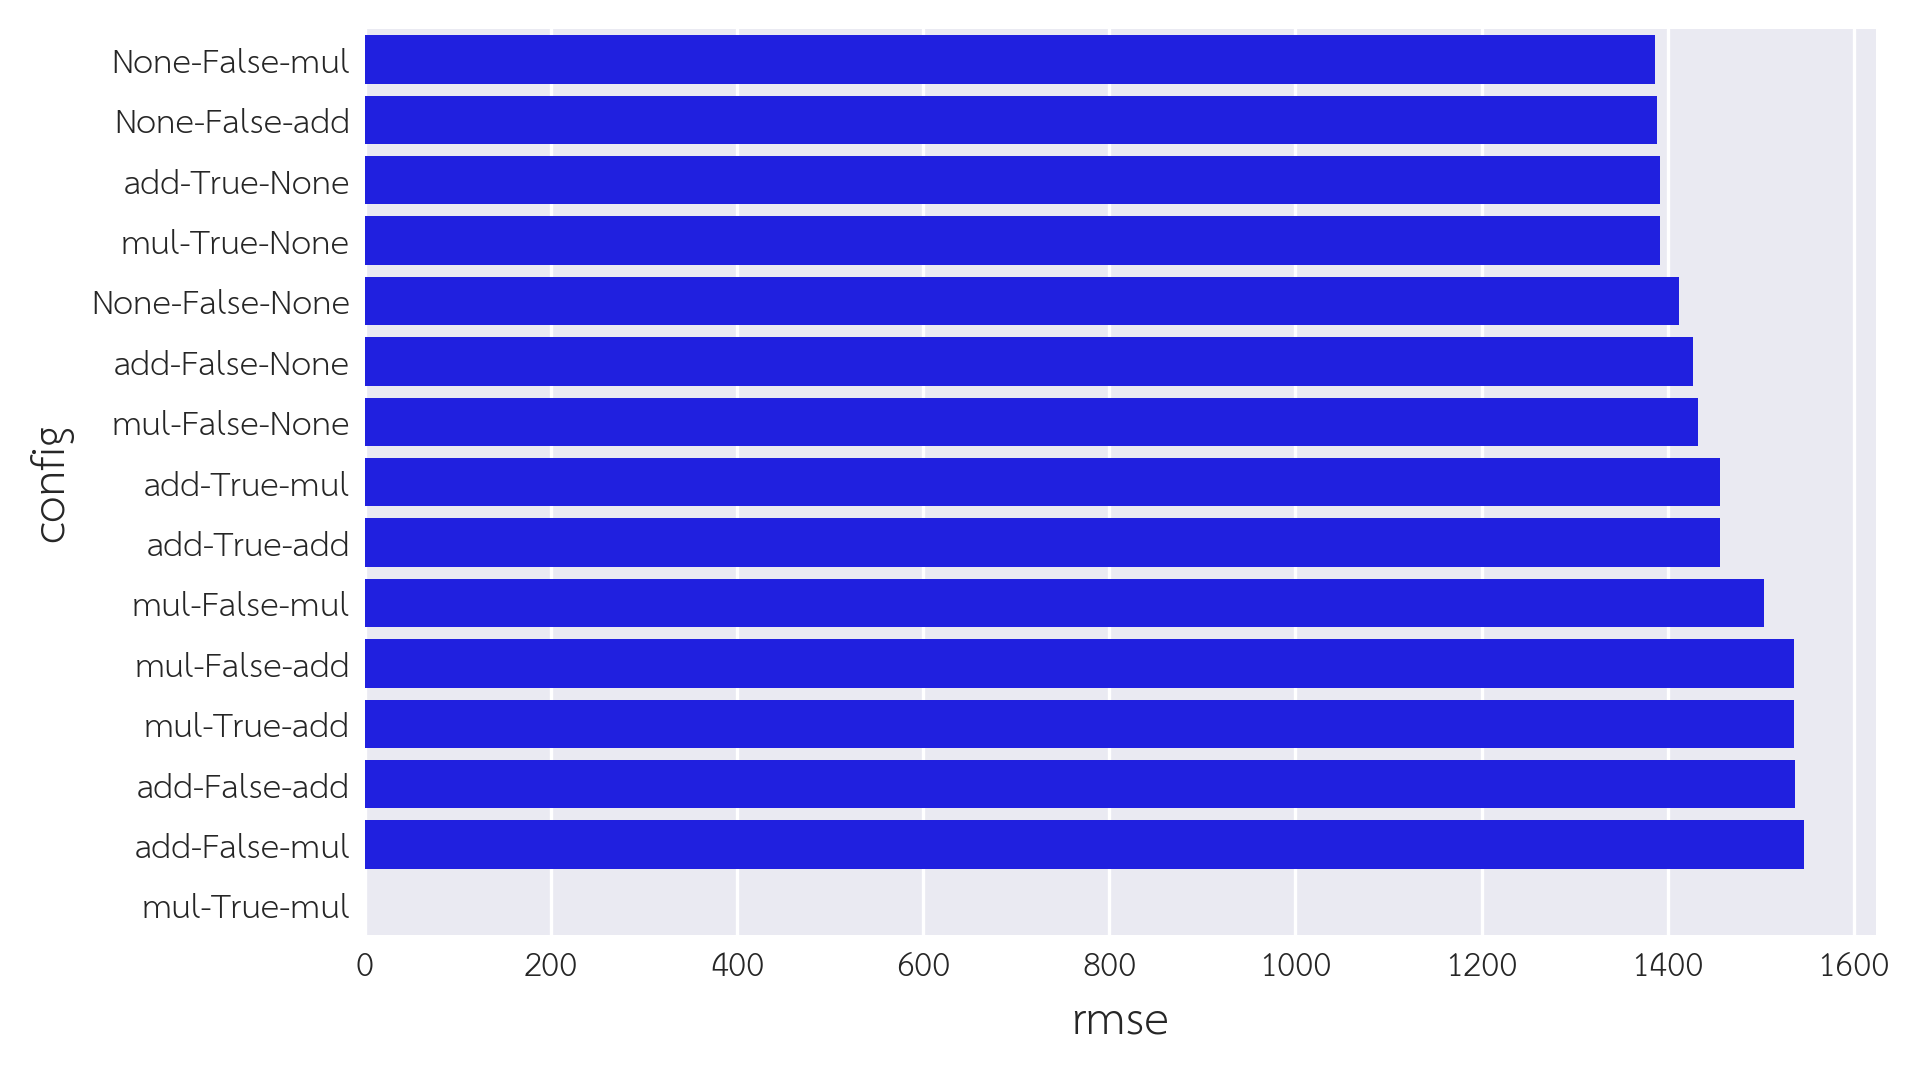

In [50]:
sns.barplot(data=glu.ets_grid_result.reset_index().sort_values('rmse'),
            x="rmse", y='config', color = 'b')

In [135]:
hml.lstm_yhat[col34]

,yhat3,yhat4
date,,
2012-09-01,"15,853.0553","15,357.1051"
2012-10-01,"15,334.2518","15,436.7851"
2012-11-01,"15,393.5197","15,735.6601"
2012-12-01,"15,757.7018","16,124.7099"
2013-01-01,"16,117.4896","15,920.1778"
...,...,...
2019-02-01,"15,816.1903","15,735.5045"
2019-03-01,"15,704.3212","15,789.7407"
2019-04-01,"15,773.9215","15,831.8477"


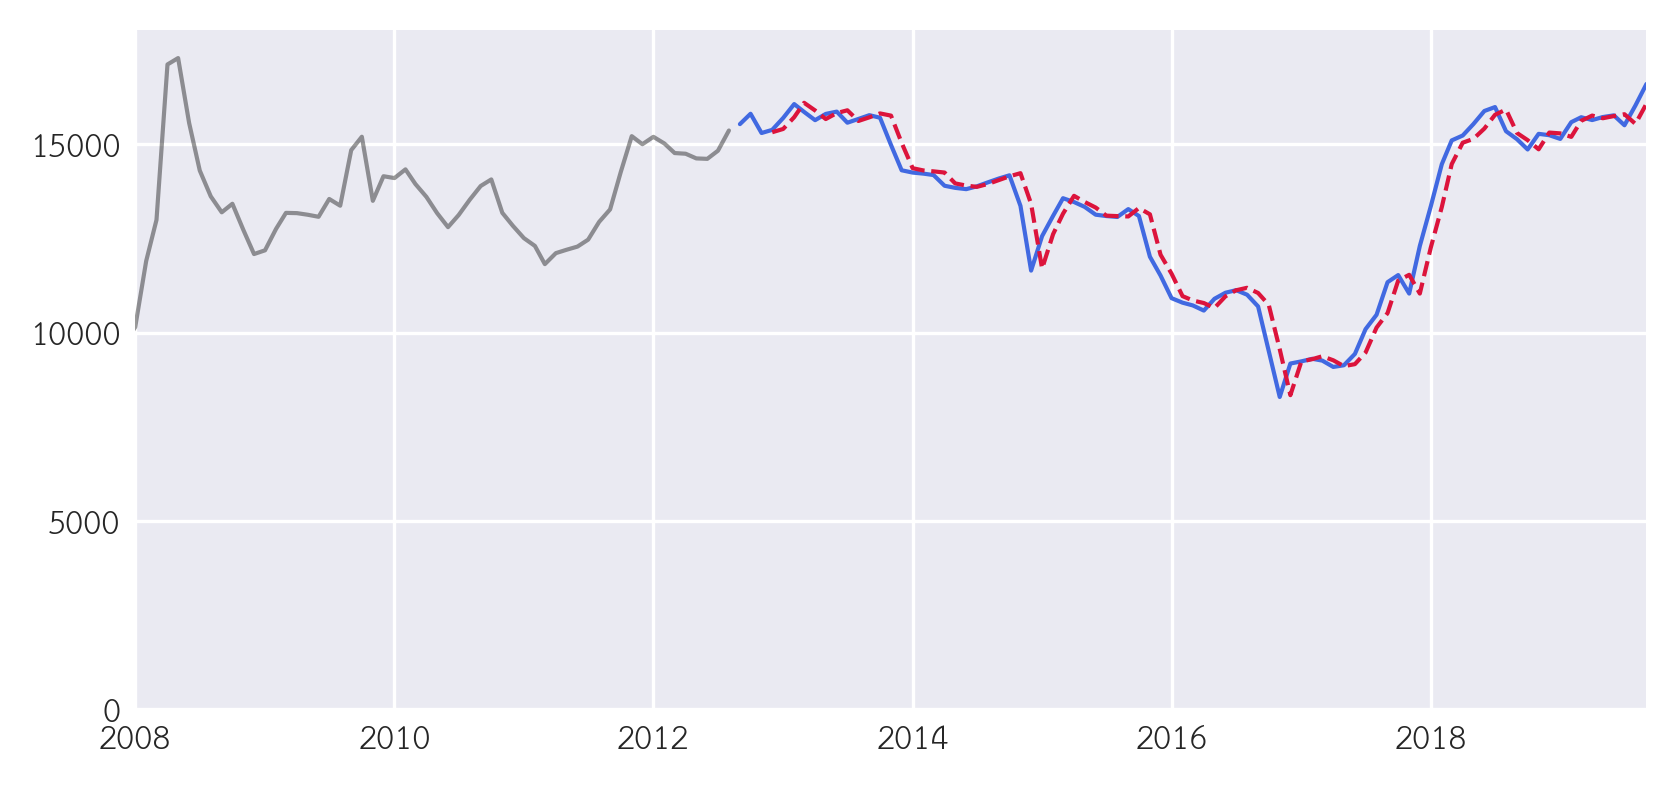

In [13]:
plot_fcast(hml, 'mixed', step=4)

In [96]:
def my_plot(ax, data, method='ets', step=1):
    """
    Plot forecast vs actual
    """
    
    train, validate, train2, test = data_split(data)
    yhat  = getattr(data, f'{method}_yhat')
    yhat = data.join(yhat)
    
    years = mdates.YearLocator()
    ax.plot(train2, color='black', alpha=0.4, lw=1)
    ax.plot(test, color='royalblue', lw=1)
    ax.plot(yhat[f'yhat{step}'].shift(step-1), color='crimson', ls='dashed', lw=1)
    ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2019, 9, 1)])
    ax.set_ylim(5000)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    sns.despine(bottom=False, left=True, ax=ax)
    
def combine_plot(method):
    fig, axes = plt.subplots(nrows=3, ncols=4, sharex="col", sharey='row', figsize=(10, 6))
    for i, price in enumerate(prices):
        for h in range(4):
            ax = axes[i, h]
            if i == 0:
                ax.set_title(f"h={h+1}", loc='right')
            if h == 0:
                ax.set_title(f"ราคา{price.meta.shortname}", loc='left')
            my_plot(ax, price, method=method, step = h+1)
    return fig

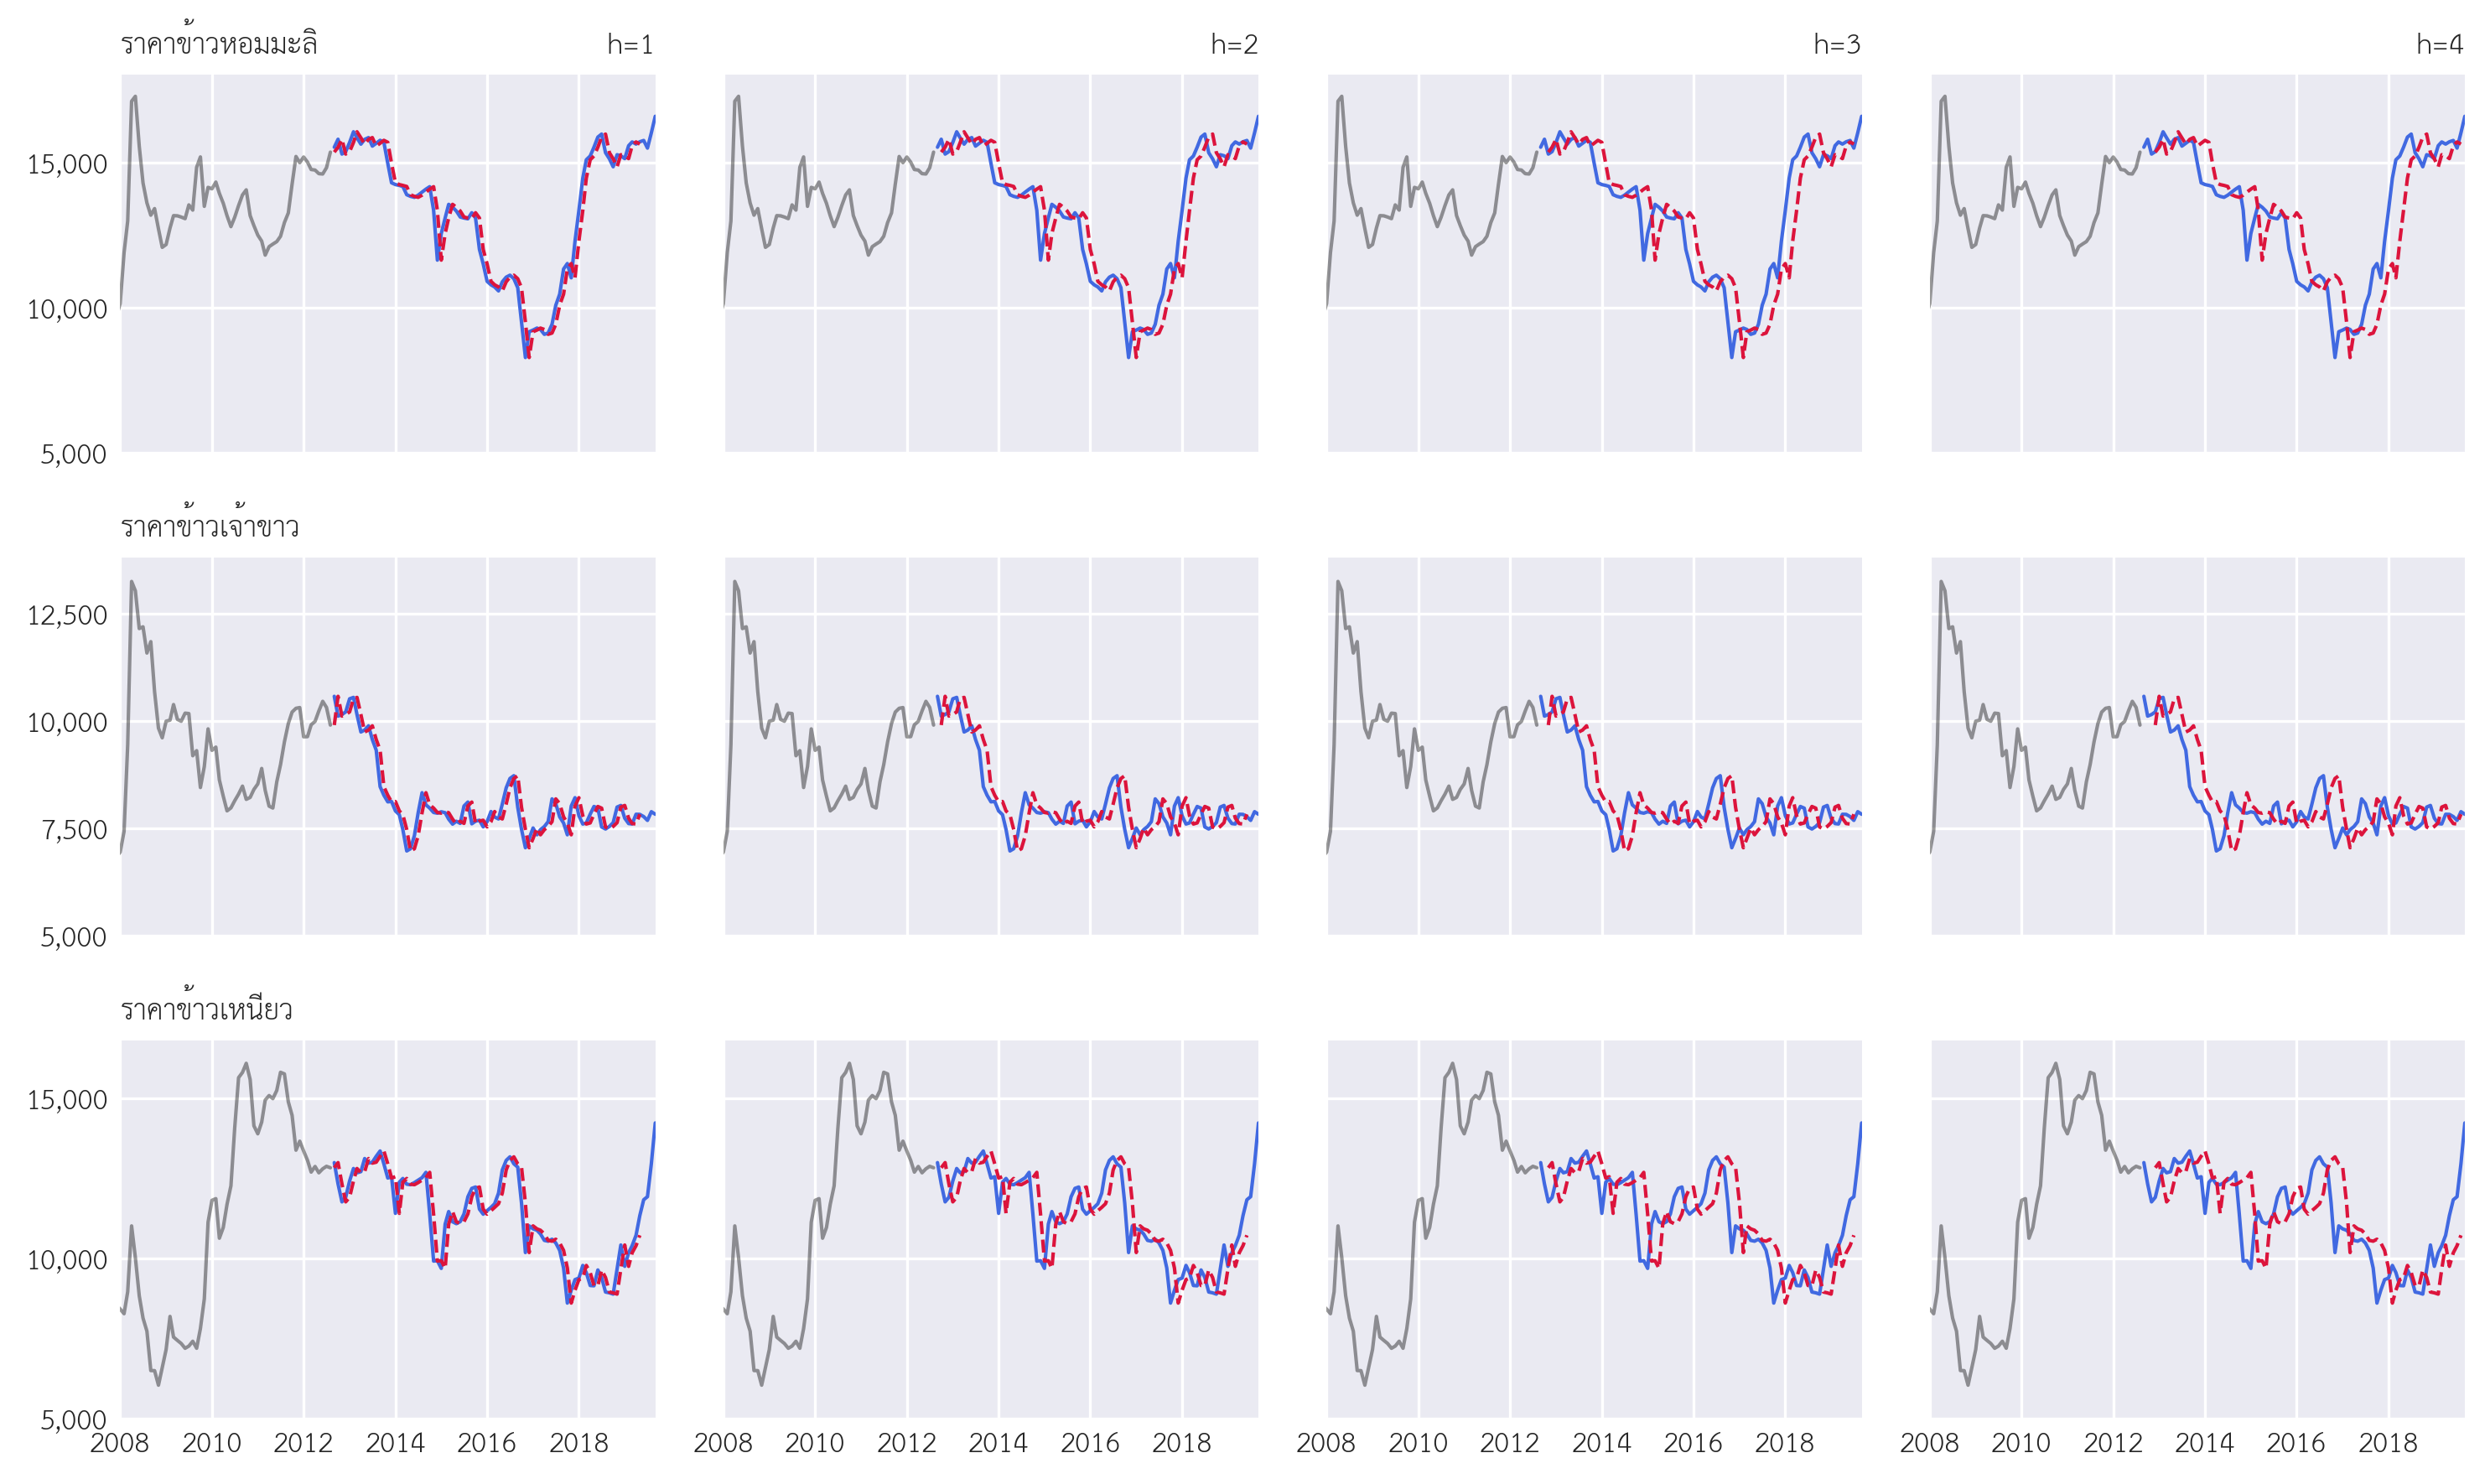

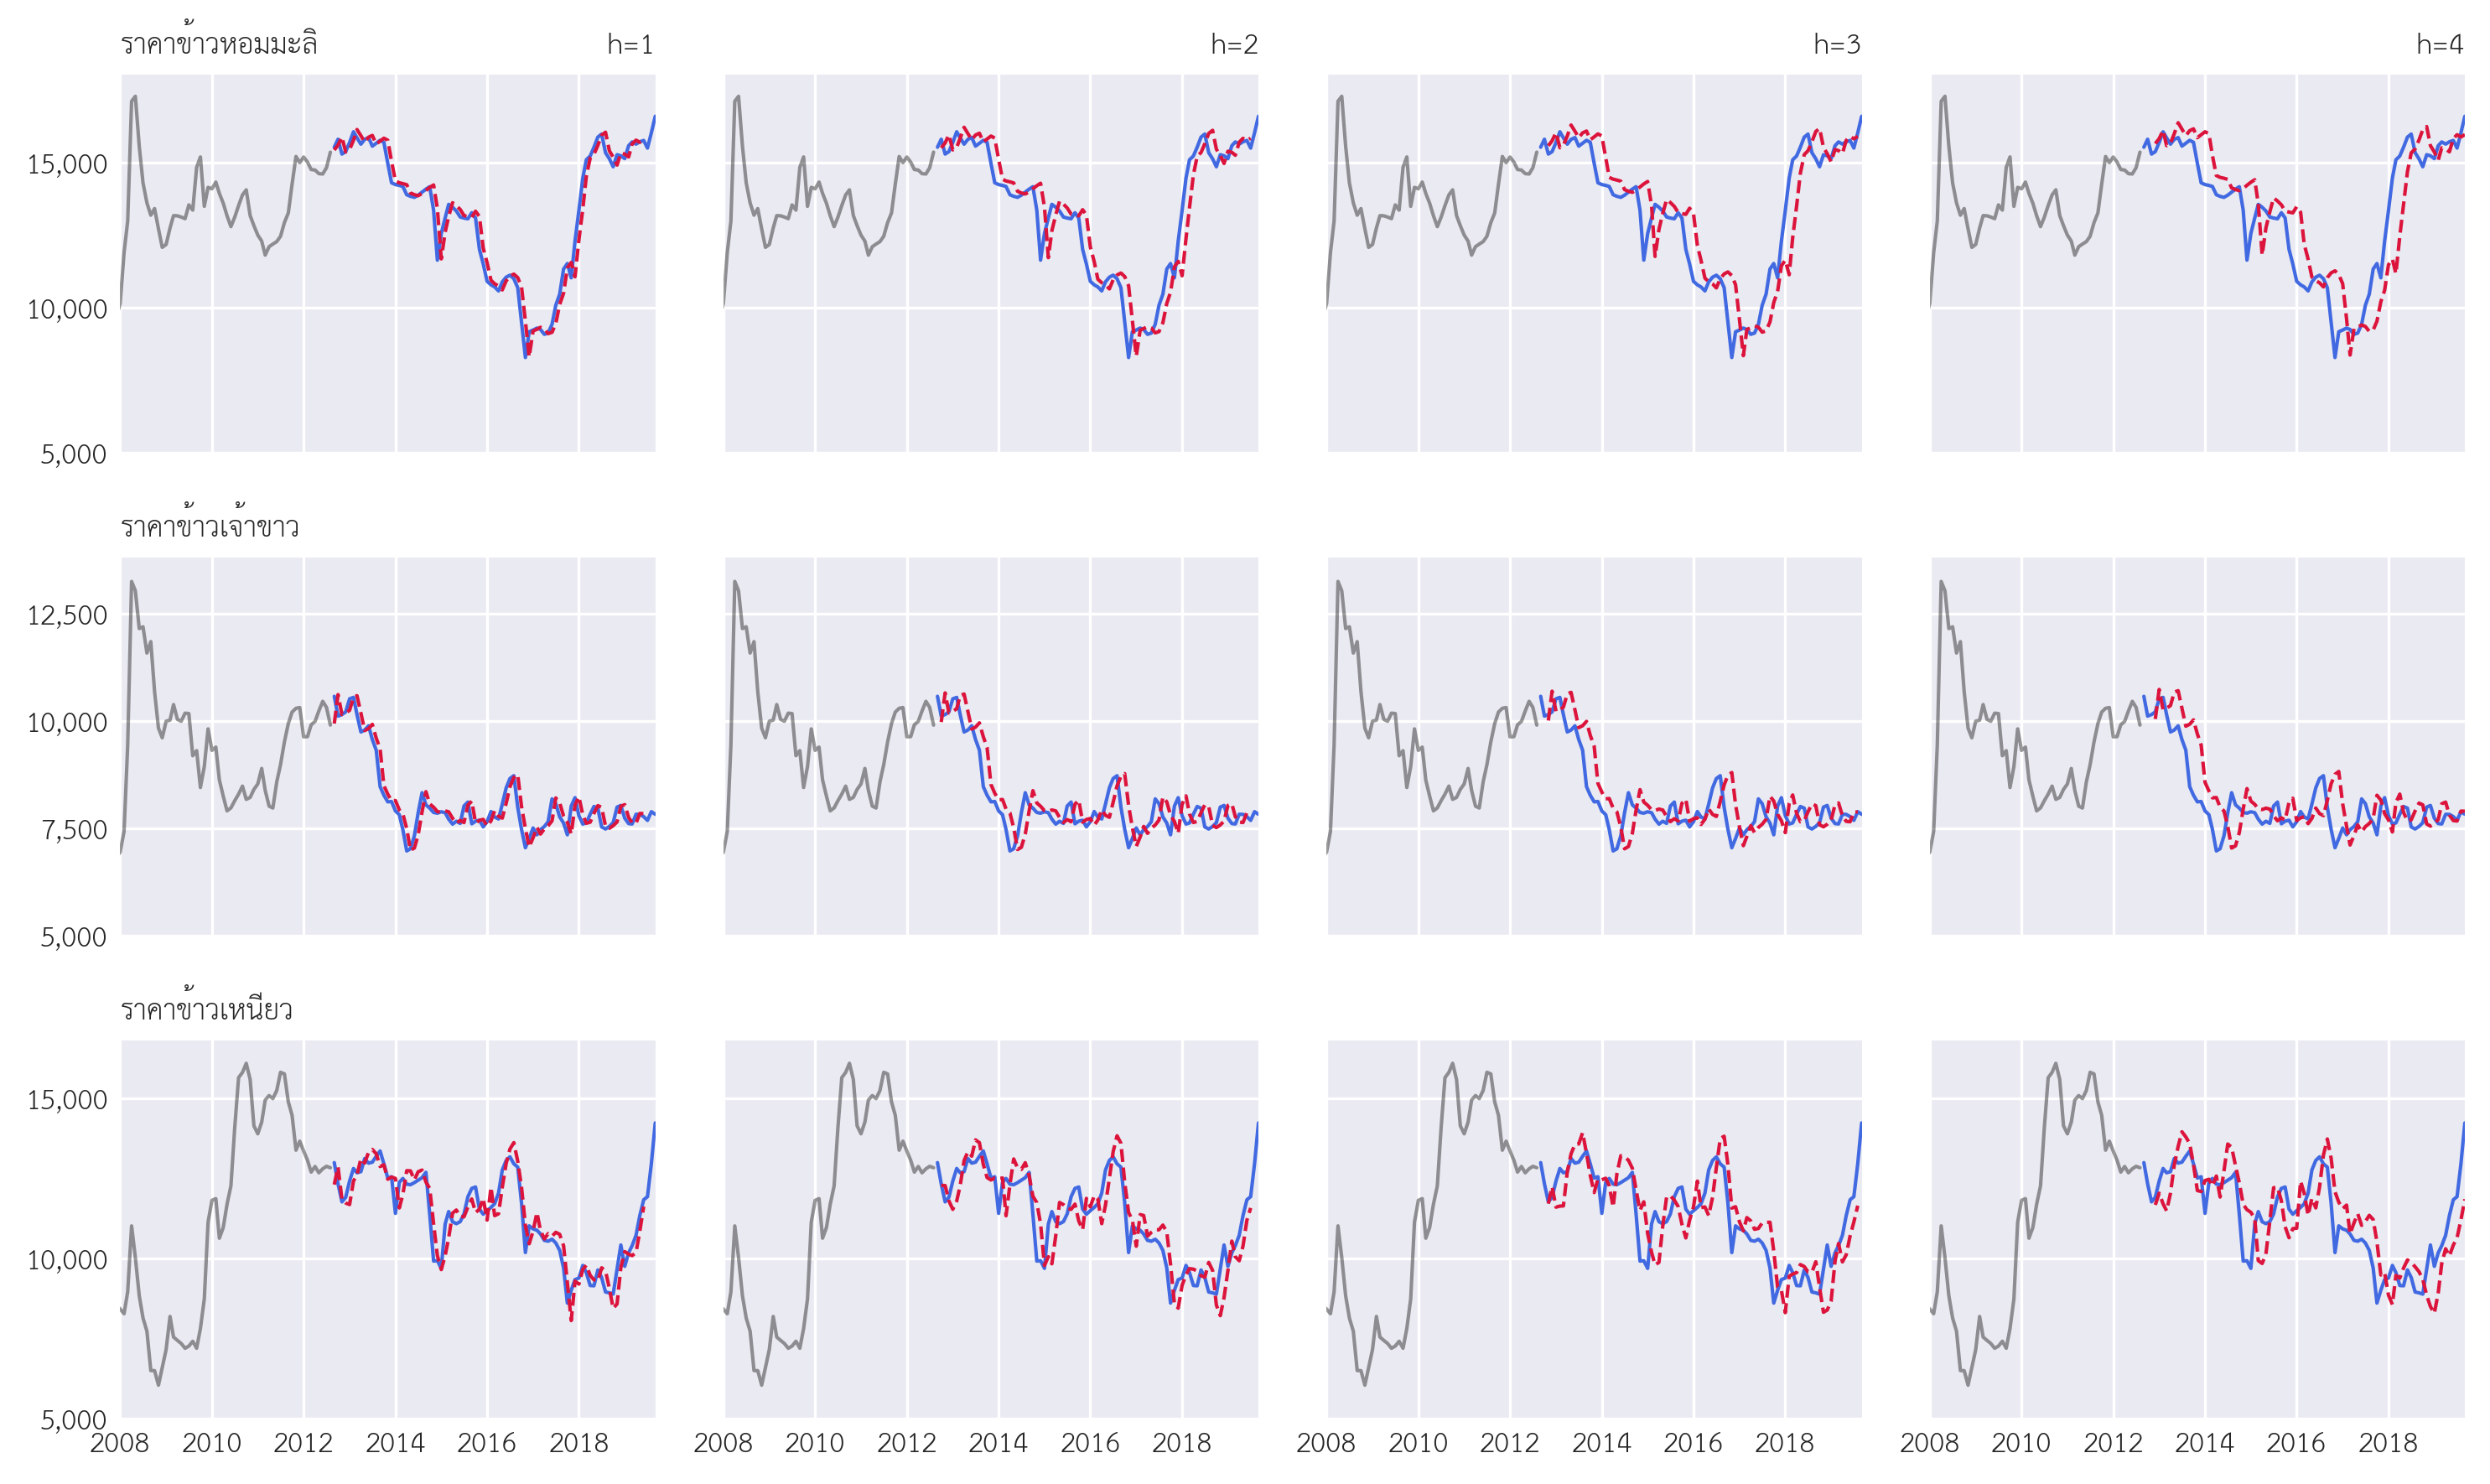

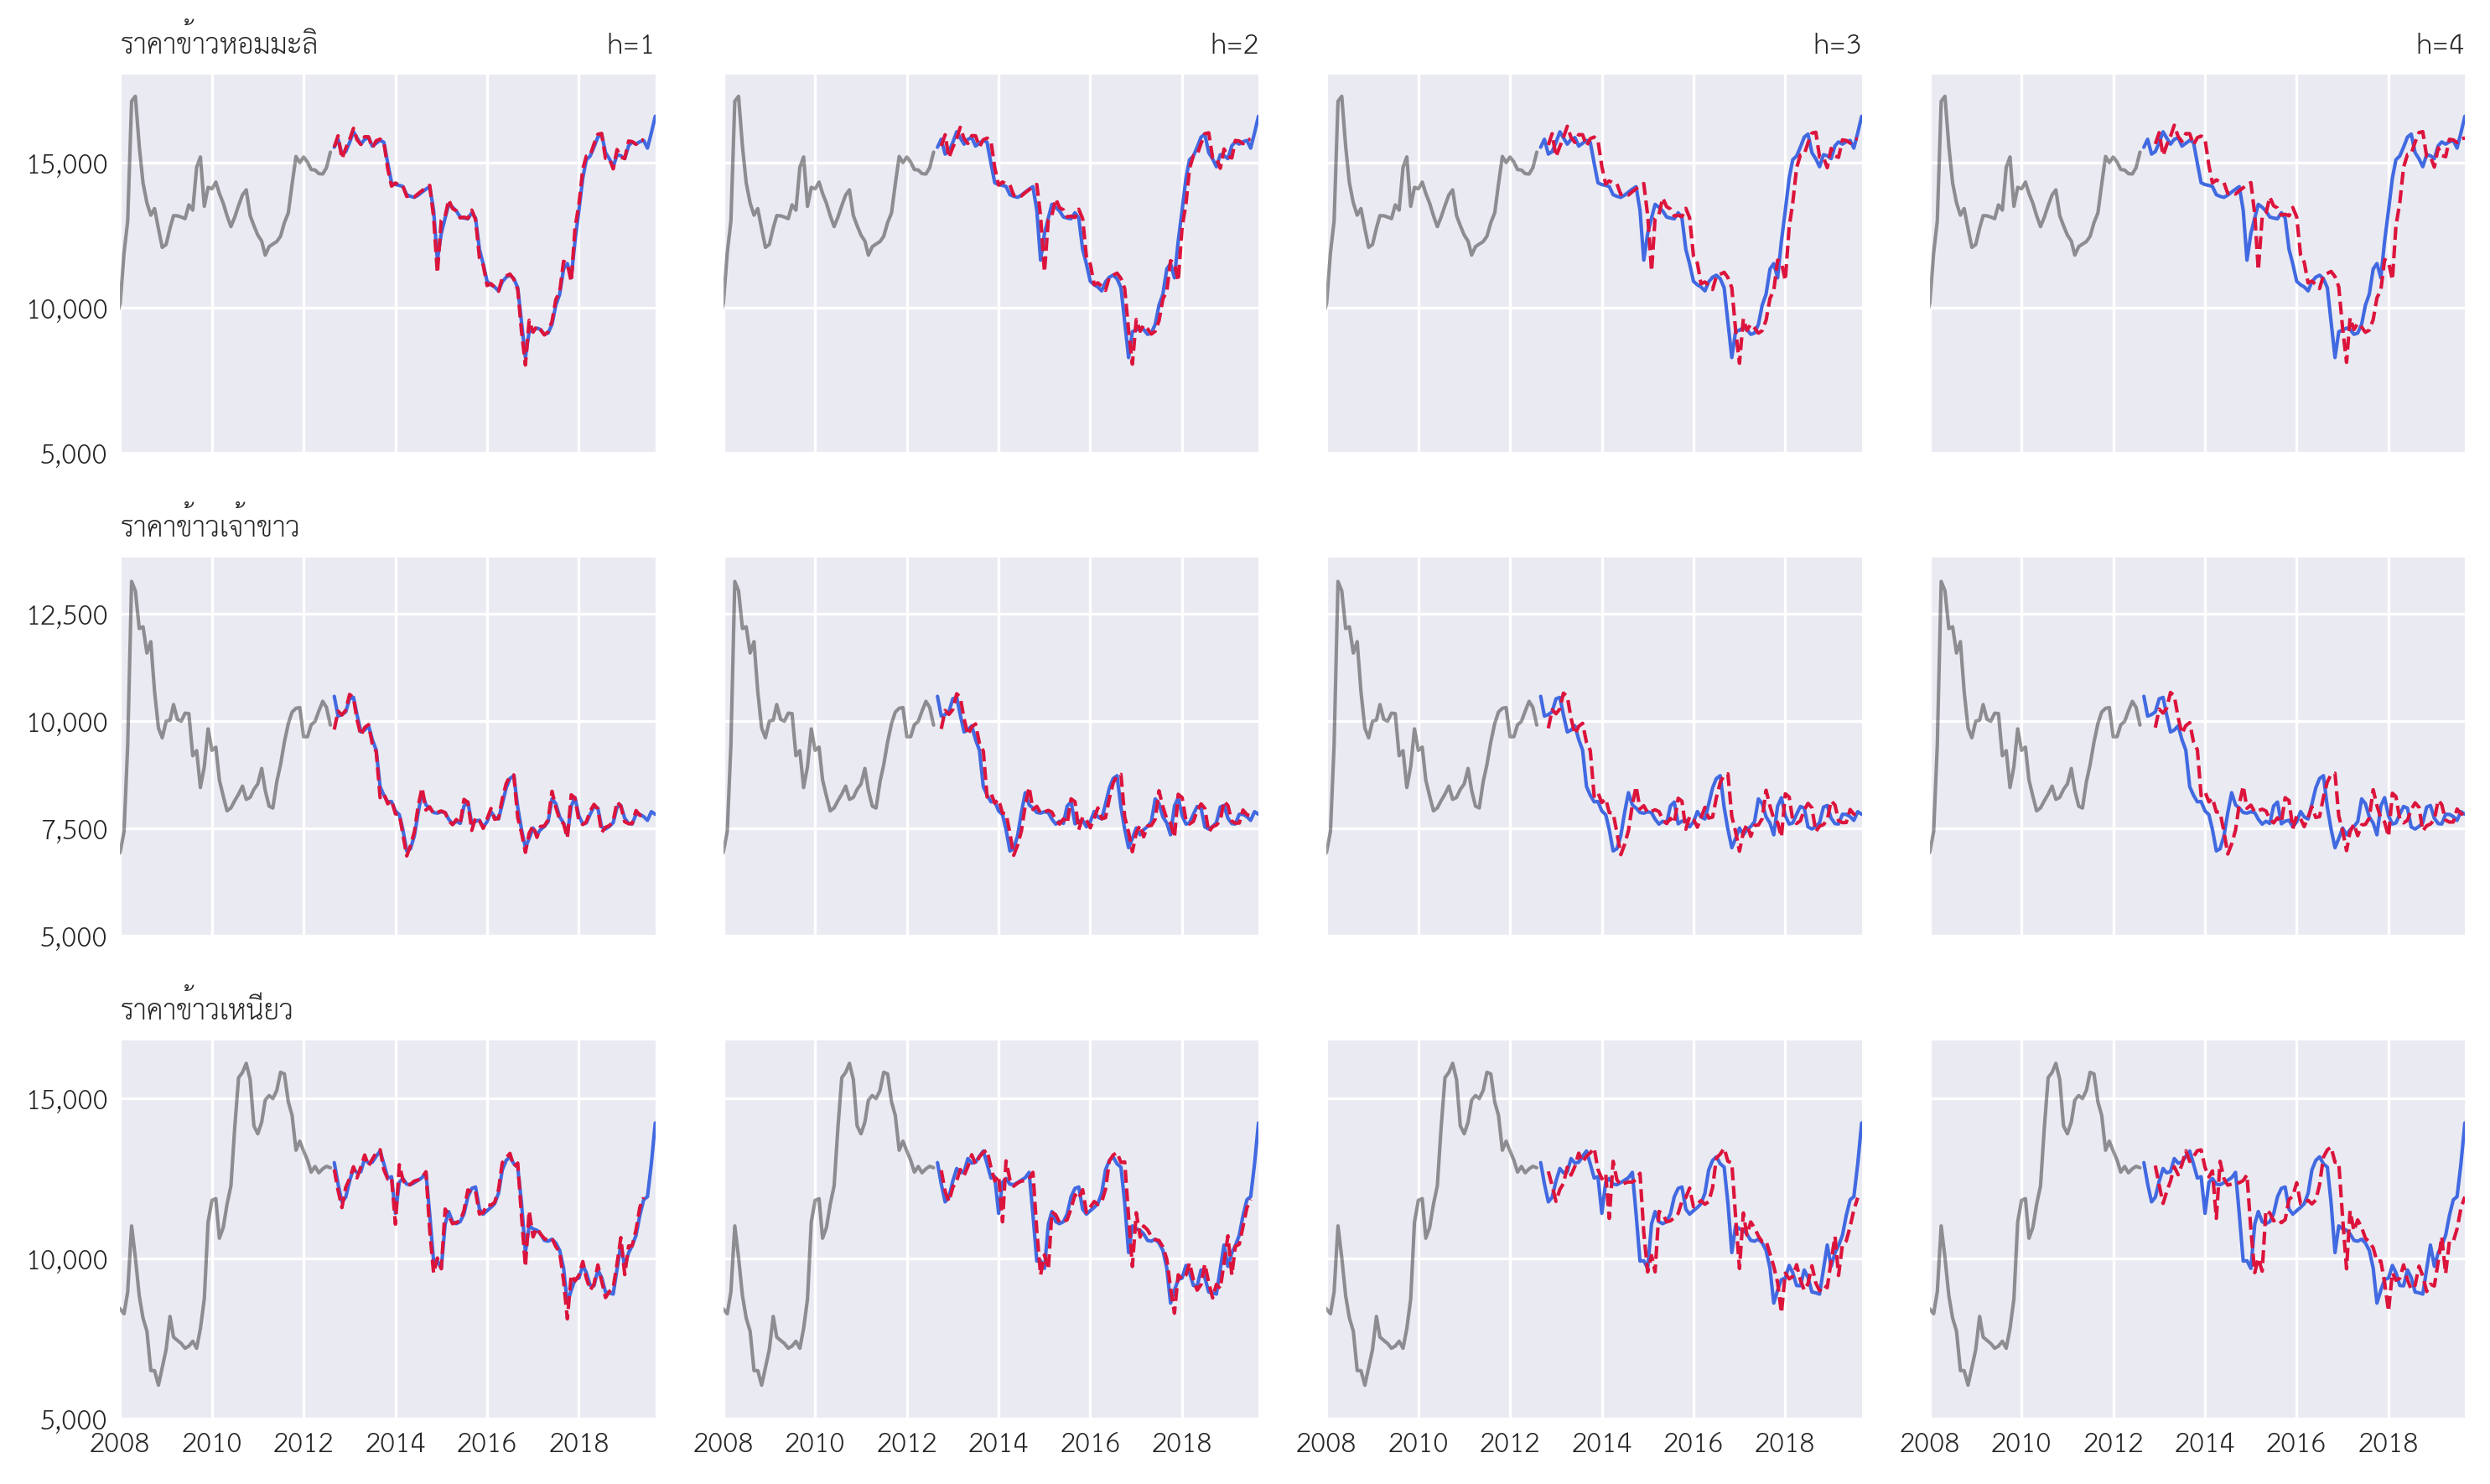

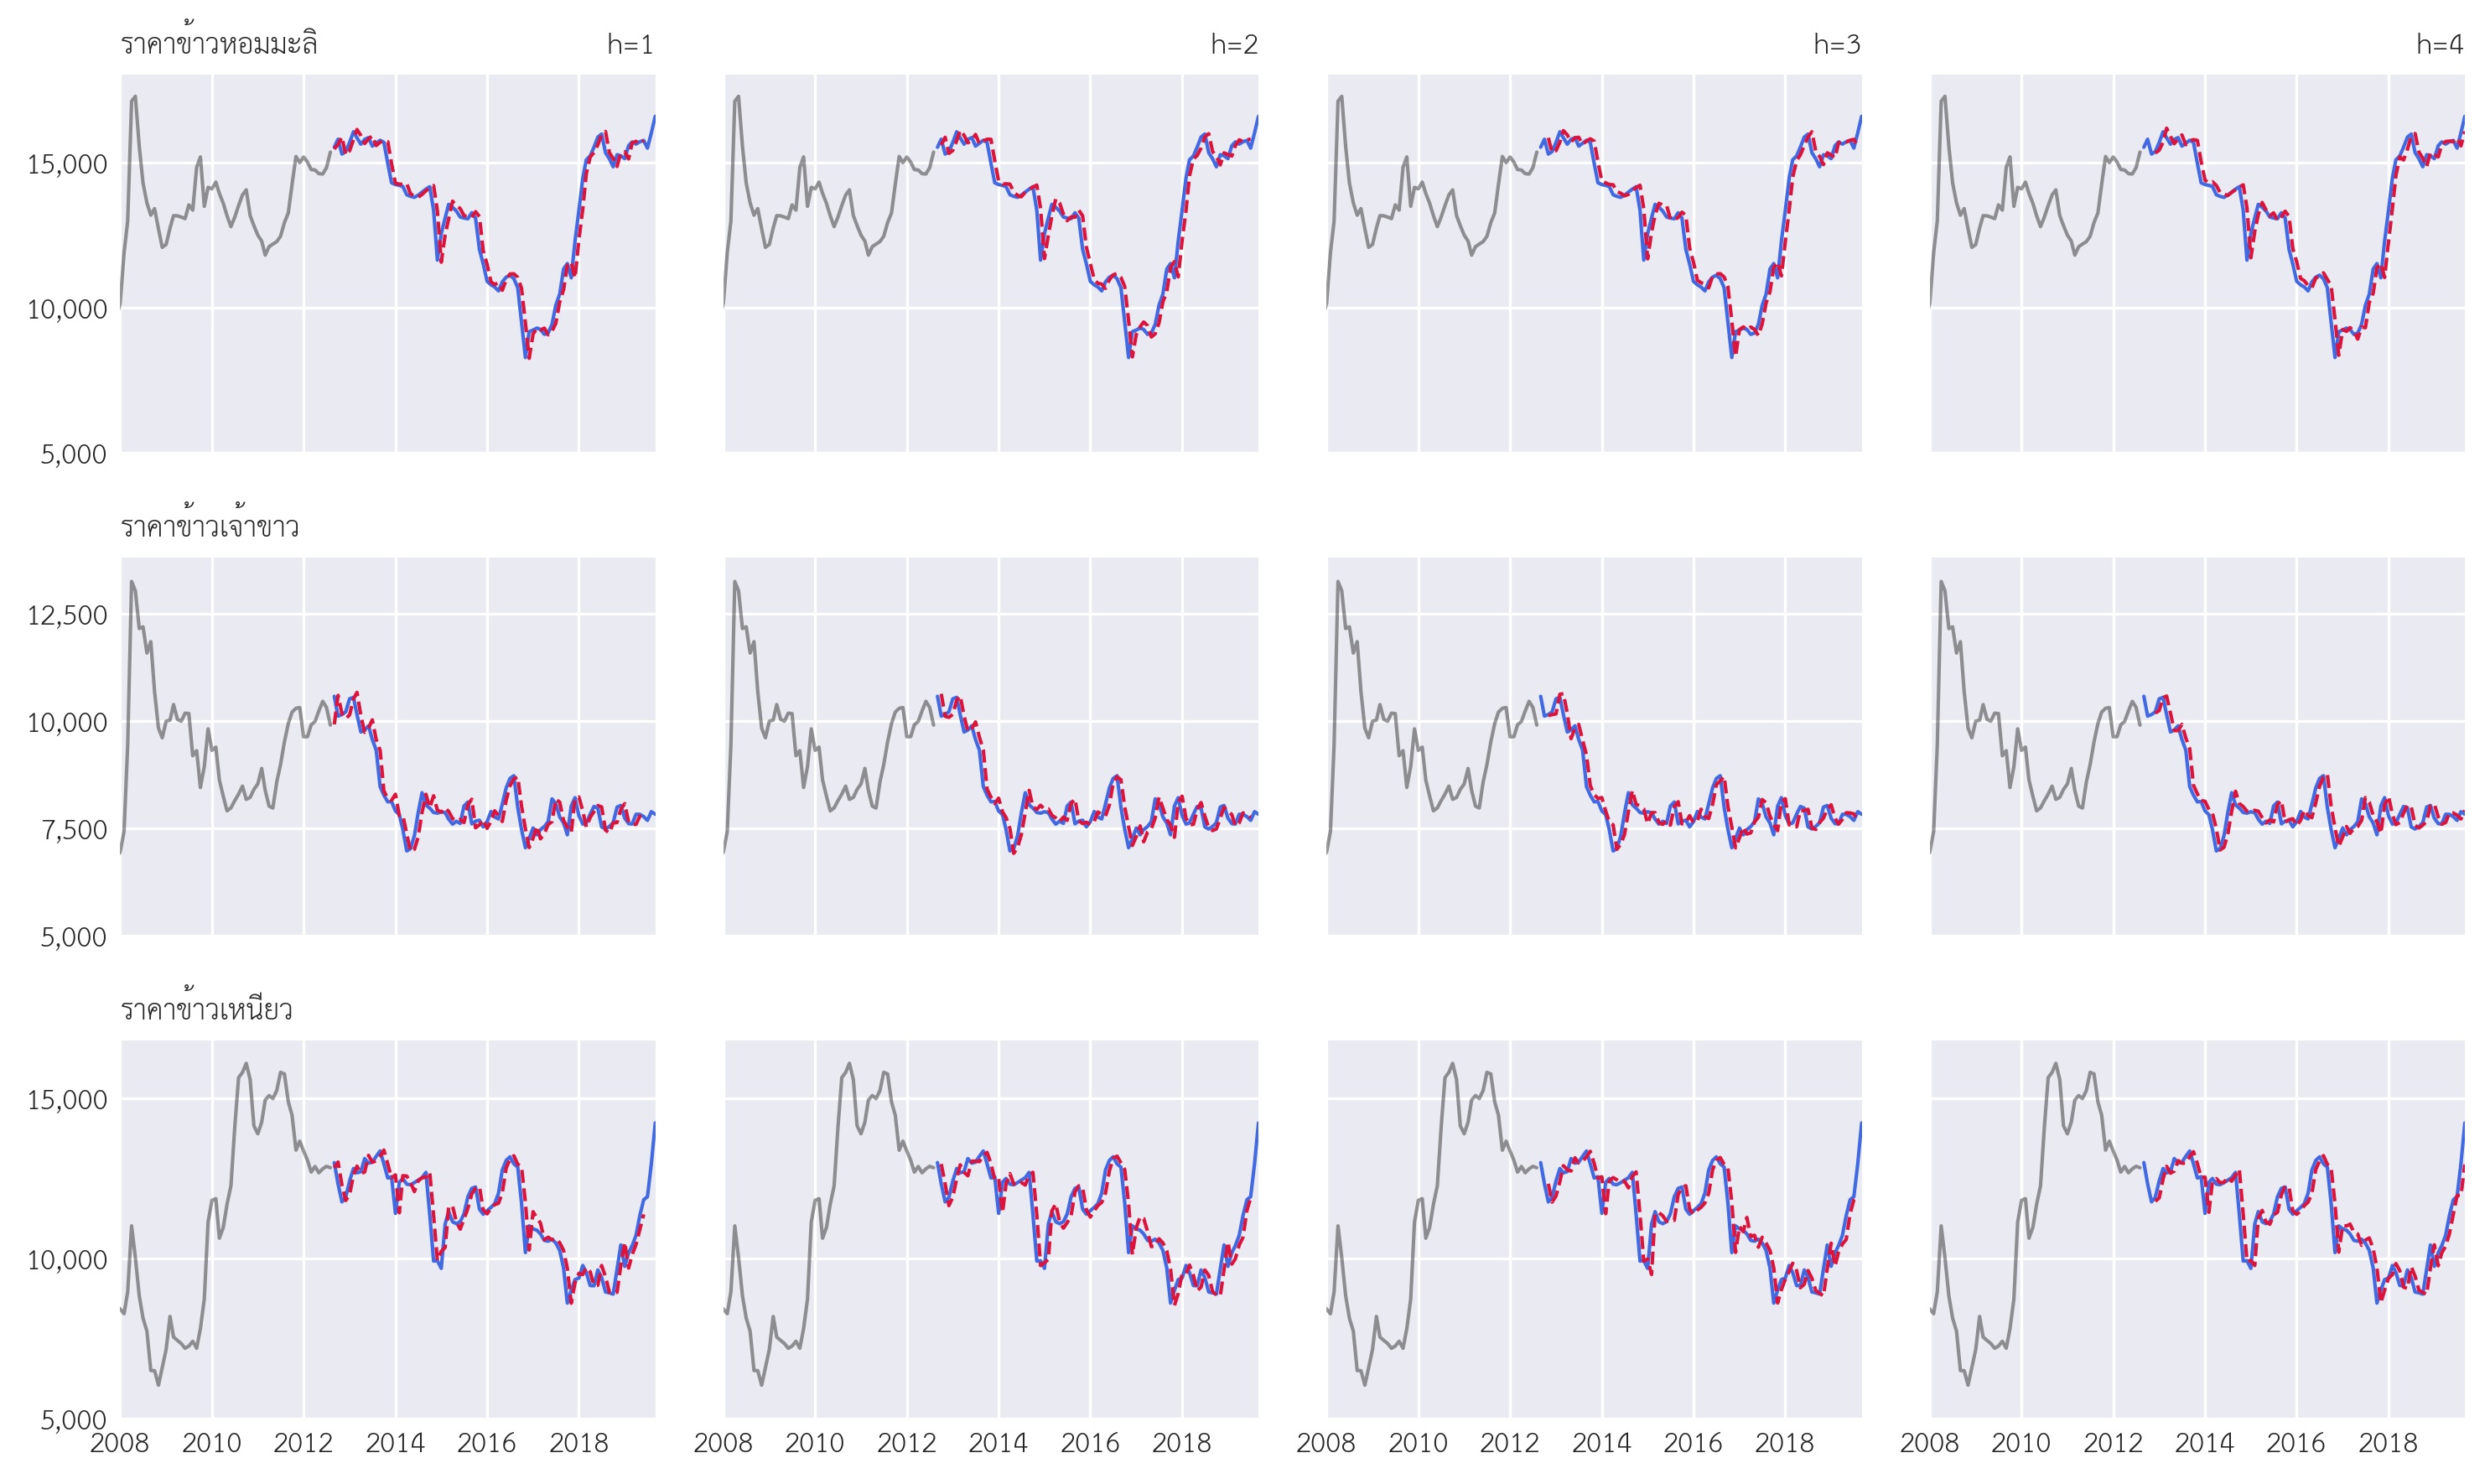

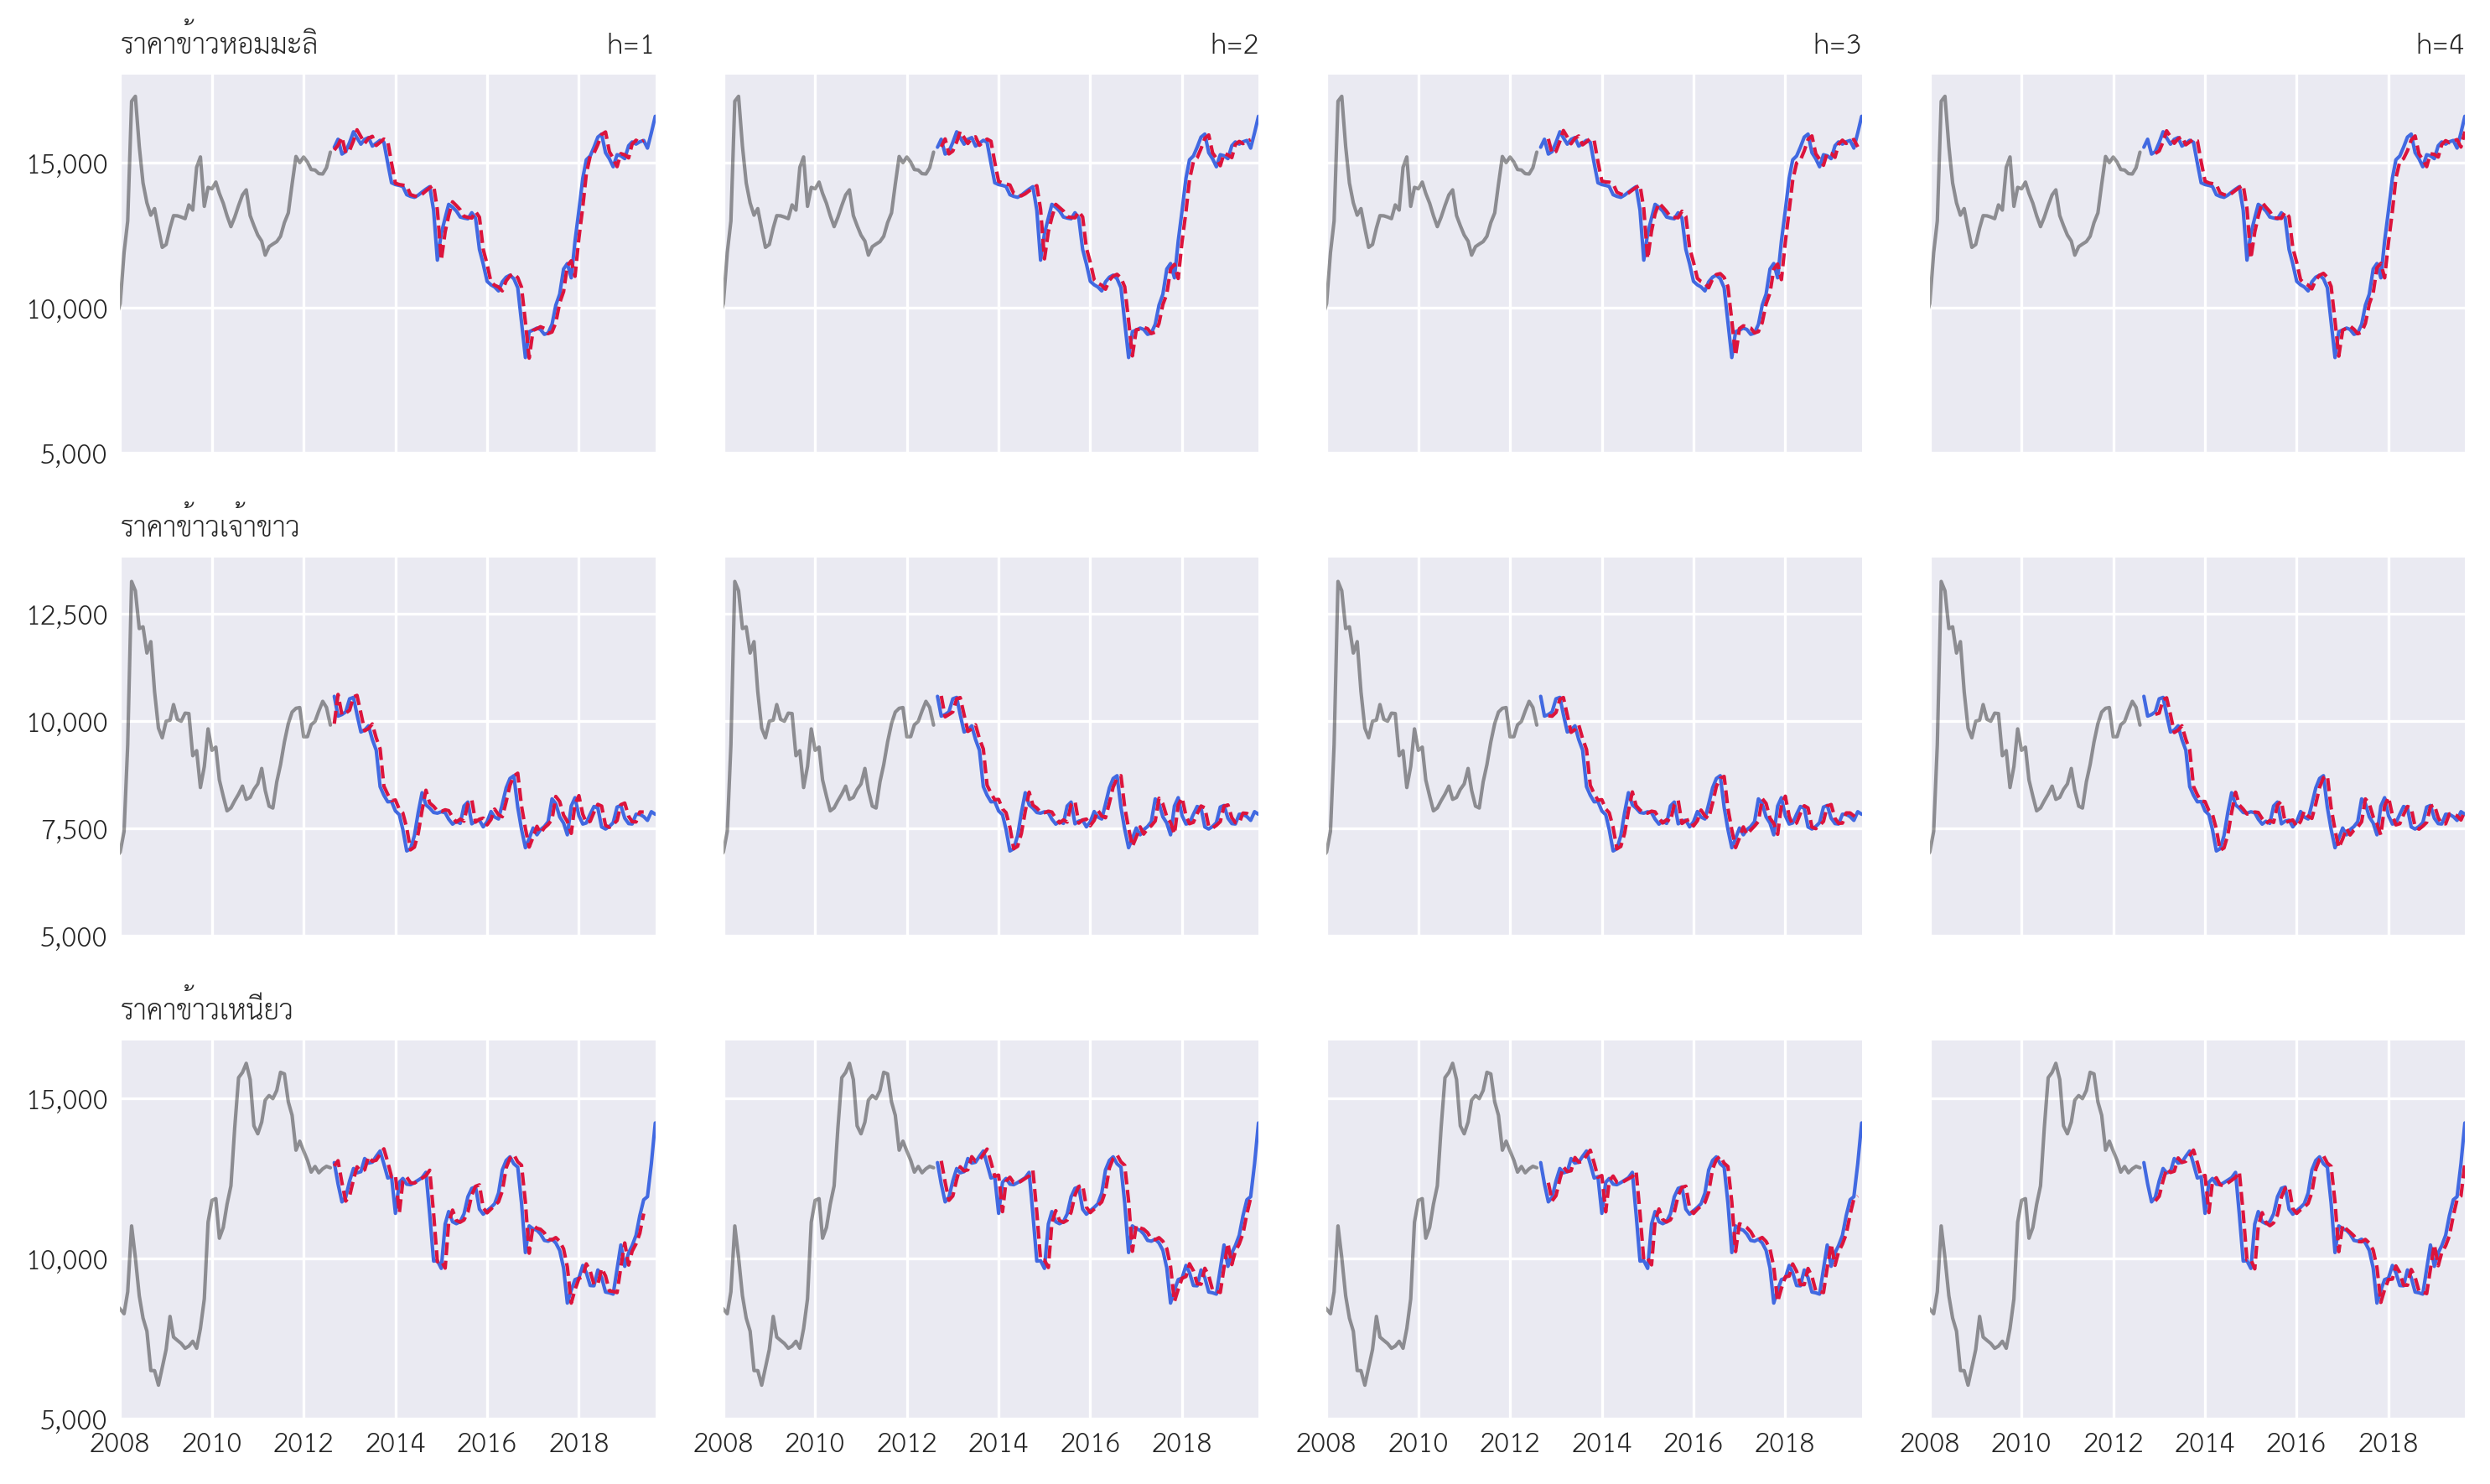

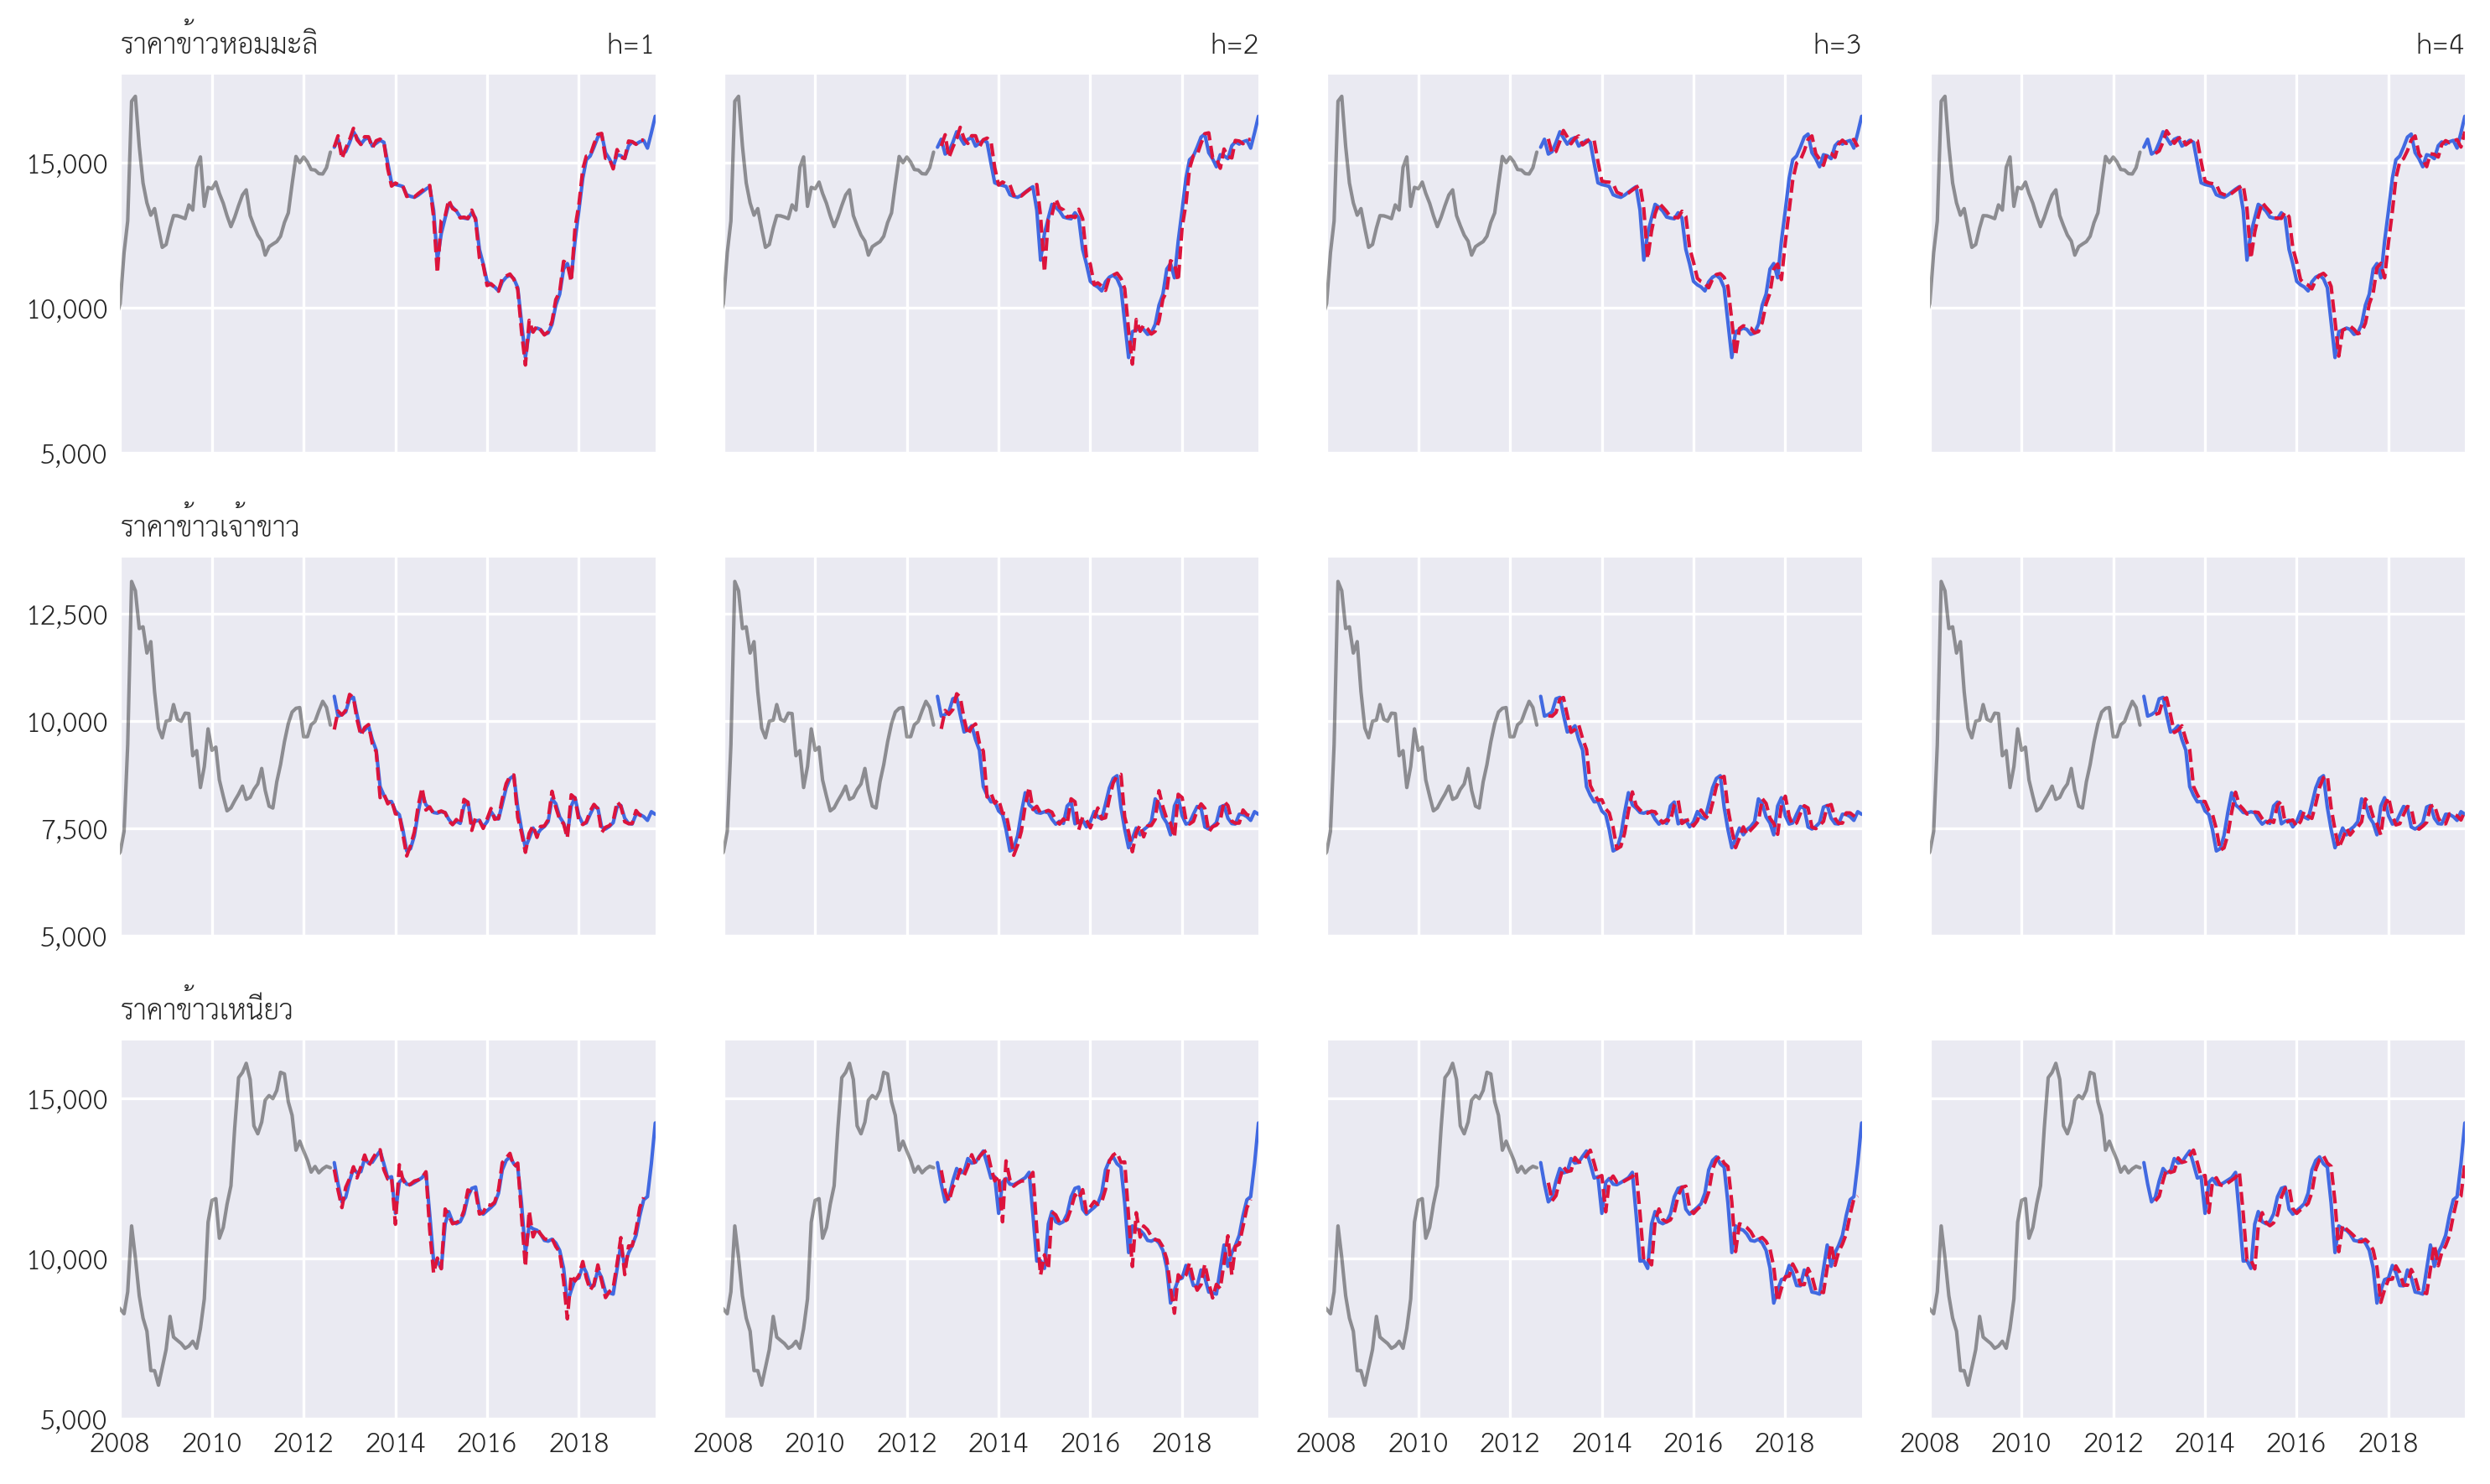

In [103]:
models = ['naive', 'ets', 'arima', 'mlp', 'lstm', 'mixed']

for model in models:
    fig = combine_plot(method=model)
    plt.tight_layout()
    fig.savefig(f'../figures/fcast_{model}.png', dpi=300)